# Assignment 2
> **Github repository**: [Assignment 2](https://github.com/josephnguyen0413/02467_Assignment2)
>
> **Group members**:
> - Rune Harlyk (s234814)
> - Joseph Nguyen (s234826)
> - Julius Winkel (s234862)

We have all worked together on the code and answering questions.

## Part 0

In [68]:
import networkx as nx
import json
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
import netwulf as nw
import matplotlib.pyplot as plt
import seaborn as sns
import random
from joblib import delayed, Parallel
from collections import defaultdict
from community import community_louvain
from wordcloud import WordCloud
import ast
from functools import lru_cache
# import nltk.book as book
from nltk import PorterStemmer
import nltk
import re
sns.set_theme(style="darkgrid")
from nltk.corpus import stopwords
seed = 42
np.random.seed(seed)
random.seed(seed)

In [65]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\juliu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Part 1: Properties of the real-world network of Computational Social Scientists

> * First, calculate the probability (_p_) that makes the expected number of edges in our random network match the actual edge count in the Computational Social Scientists network. Refer to equation 3.2 in your Network Science textbook for guidance. After finding _p_, figure out the average degree (using the given formula). 

$$ p = \frac{2L}{N(N-1)} $$

$$ k = p(N-1) $$

In [25]:
def load_graph(graph_file):
    with open(graph_file, "r") as f:
        data = json.load(f)
    G = nx.readwrite.json_graph.node_link_graph(data)
    return G

graph_file = "ic2s2_coauthors_graph.json"
G = load_graph(graph_file)
N = G.number_of_nodes()
L = G.number_of_edges()
print(f"Number of nodes: {N}, Number of edges: {L}")

Number of nodes: 14139, Number of edges: 57661


c:\Users\juliu\Miniconda3\Lib\site-packages\networkx\readwrite\json_graph\node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(


In [8]:
def edge_prob(N, L):
    return (2 * L) / (N * (N - 1))

def expected_degree(p, N):
    return p * (N - 1)

p = edge_prob(N, L)
k = expected_degree(p, N)
print(f"Edge probability: {p:.4f}, Expected degree: {k:.4f}")

Edge probability: 0.0006, Expected degree: 8.1563


> * Now, write a function to generate a Random Network that mirrors the Computational Social Scientists network in terms of node count, using your calculated _p_. Generate a random network by linking nodes in every possible pair with probability _p_. **Hint**: you can use the function [``np.random.uniform``](https://numpy.org/doc/stable/reference/random/generated/numpy.random.uniform.html) to draw samples from a uniform probability distribution.   

In [9]:
def random_network(G, seed = 42):
    random.seed(seed)
    N = G.number_of_nodes()
    L = G.number_of_edges()
    p = edge_prob(N, L)
    G_random = nx.erdos_renyi_graph(N, p, seed=seed)
    country_codes = [data['country_code'] for _, data in G.nodes(data=True) if 'country_code' in data]
    nx.set_node_attributes(G_random, {n: {'country_code': random.choice(country_codes)} for n in G_random})
    return G_random

G_random = random_network(G, seed)
print(f"Number of nodes for random network: {G_random.number_of_nodes()}, Number of edges for random network: {G_random.number_of_edges()}")

Number of nodes for random network: 14139, Number of edges for random network: 57596


> * Visualize the network as you did for the Computational Social Scientists network in the exercise above (my version is below). 


TypeError: 'NoneType' object is not subscriptable

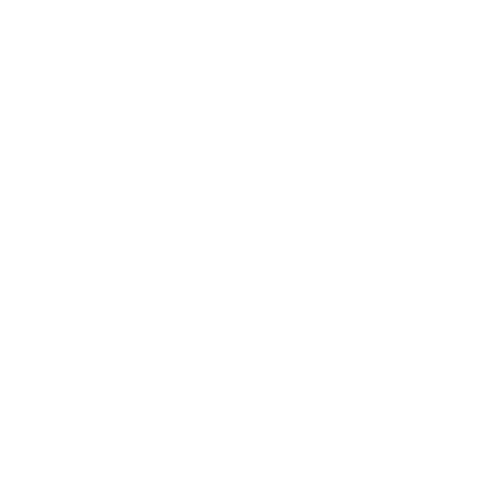

In [5]:
network, config = nw.visualize(G_random)

# draw links only at first
nw.draw_netwulf(network)

> * Answer the following questions __(max 200 words in total)__: 
>    - What regime does your random network fall into? Is it above or below the critical threshold?  
>    - According to the textbook, what does the network's structure resemble in this regime?  
>    - Based on your visualizations, identify the key differences between the actual and the random networks. Explain whether these differences are consistent with theoretical expectations.

In [10]:
L_random = G_random.number_of_edges()
p_random = edge_prob(N, L_random)
p_c = 1 / N
print(f'p: {p_random:.4f}, p_critical: {p_c:.4f}')

p: 0.0006, p_critical: 0.0001


- Since $p \gt p_c$, the random network is a supercritical regime according to section 3.6 in the book "Network Science". That means the random network is above the critical threshold. 
- $\dots$
- One property of real-world networks are that they are heavy tailed distributions. In our case, the top author in the real network had a degree of 339, but for the random network, the top author only has a degree of 22.

> 2. _Shortest Paths_: Here, we will check if the Computational Social Scientists Network exhibits characteristics of a small-world network by analyzing its shortest paths.
> * Begin by identifying the largest connected component within the Computational Social Scientists network. Recall that a connected component is a subset of nodes in which every pair of nodes is connected by a path. For a refresher on connected components, see section 2.9 of the Network Science book. Follow these steps:
>    - Utilize [``nx.algorithms.connected_components``](https://networkx.org/documentation/stable//reference/algorithms/generated/networkx.algorithms.components.connected_components.html) to enumerate all connected components, which will be returned as a list of node subsets.
>    - Select the largest subset of nodes identified in the previous step. Then, create a subgraph of your original network that includes only these nodes, using [``nx.Graph.subgraph``](https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.subgraph.html). This subset forms your largest connected component, sometimes referred to as the [giant component](https://en.wikipedia.org/wiki/Giant_component).


In [11]:
cc = nx.algorithms.connected_components(G)
largest_cc = max(cc, key=len)
giant_component = G.subgraph(largest_cc).copy()

> * Calculate the average (unweighted) shortest path length within this giant component by employing [``nx.average_shortest_path_length``](https://networkx.org/documentation/networkx-1.3/reference/generated/networkx.average_shortest_path_length.html).

In [8]:
nx.average_shortest_path_length(giant_component) 

5.168259510783142


> * Perform the same calculation for the giant component of the random network you constructed in the above exercise 1.


In [12]:
N = giant_component.number_of_nodes()
L = giant_component.number_of_edges()
p = edge_prob(N, L)
k = expected_degree(p, N)
print(f"Edge probability: {p:.4f}, Expected degree: {k:.4f}")

Edge probability: 0.0006, Expected degree: 8.3073



> * Reflect on how the average shortest path lengths of the real and random networks compare and answer the following questions, supporting your answers with the theory from the book.
>   - Why do you think I asked you to consider the giant component only?
>   - Why do you think I asked you to consider unweighted edges?
>   - Does the Computational Social Scientists network exhibit the small-world phenomenon?

## Part 2 Network Analysis in Computational Social Science

> __Exercise 1: Mixing Patterns and Assortativity__ 
>


> __Part 1: Assortativity Coefficient__ 
> 1. *Calculate the Assortativity Coefficient* for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in [this paper](https://arxiv.org/pdf/cond-mat/0209450.pdf) (equation 2, here for directed networks). **Do not use the NetworkX implementation.**
>


We use the formula:

$$
r = \frac{\sum_i e_{ii} - \sum_i a_i b_i}{1 - \sum_i a_i b_i}
$$


In [13]:
def assortativity_coefficient(G, attribute):
    mixing_matrix = nx.attribute_mixing_matrix(G, attribute) 

    # Sum by row to get a_i
    ai = np.sum(mixing_matrix, axis=0)

    # sum by column to get b_i
    bi = np.sum(mixing_matrix, axis=1)

    # Diagonal from mixing matrix to get e_ii
    eii = np.trace(mixing_matrix)
    r = (eii - np.sum(ai*bi)) / (1 - np.sum(ai*bi))
    return r

r = assortativity_coefficient(G, 'country_code')
print(f"Assortativity coefficient: {r:.4f}")

Assortativity coefficient: 0.3882


> __Part 2: Configuration model__
> In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.  
>
> 2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
>   - **a.** Create an exact copy of your original network.
>   - **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
>   - **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are). 
>   - **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
>   - **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
>   - **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.


In [14]:
def double_edge_swap(G):
    H = G.copy()
    E = H.number_of_edges()
    total_swaps = E * 10
    edges = list(H.edges())
    swaps = 0
    while swaps < total_swaps:
        i, j = random.sample(range(E), 2)
        u, v = edges[i]
        x, y = edges[j]
        if random.random() < 0.5:
            u, v = v, u
        if u == y or v == x or H.has_edge(u, y) or H.has_edge(x, v):
            continue
        H.remove_edge(u, v)
        H.remove_edge(x, y)
        H.add_edge(u, y)
        H.add_edge(x, v)
        edges[i] = (u, y)
        edges[j] = (x, v)
        swaps += 1
    return H

H = double_edge_swap(G)
assortativity_coefficient(H, 'country_code')

0.0008190055386686307


> 3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.
>
>


In [15]:
orig_degrees = dict(G.degree())
rand_degrees = dict(H.degree())
print("Degrees preserved:", all(orig_degrees[node] == rand_degrees[node] for node in G.nodes()))

Degrees preserved: True


> __Part 3: Analyzing Assortativity in Random Networks__  
>
> 4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.
>

In [13]:
# TODO: Delete whole code cell 

# def plot_by_country(G):
#     r_values = []
#     for i in range(5):
#         G_random = random_network(G, seed = i)
#         print(nx.attribute_assortativity_coefficient(G_random, 'country_code'))
#         r_values.append(nx.attribute_assortativity_coefficient(G_random, 'country_code'))
#     plt.hist(r_values)

# plot_by_country(G)

Getting assortativity coefficients from 100 random networks

In [16]:
def assortativity_by_country(seed, G):
    G_random = random_network(G, seed=seed)
    return assortativity_coefficient(G_random, 'country_code')

def parallel_r_values(G, n_iters=100, n_jobs=-1):
    parallel_gen = Parallel(return_as="generator", n_jobs=n_jobs)(delayed(assortativity_by_country)(seed, G) for seed in range(n_iters))
    r_values = [r for r in tqdm(parallel_gen, desc="Assortativity for random graphs", total=n_iters)]
    return r_values

r_values = parallel_r_values(G)

Assortativity for random graphs:   0%|          | 0/100 [00:00<?, ?it/s]

Plotting assortativity coefficients

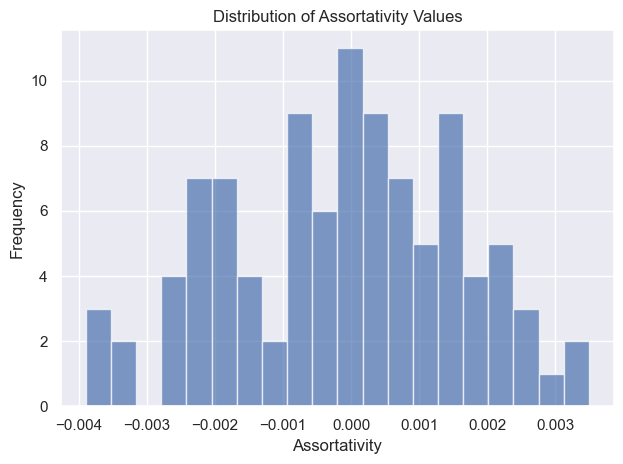

In [17]:
plt.hist(r_values, bins=20, alpha=0.7)
plt.title("Distribution of Assortativity Values")
plt.xlabel("Assortativity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

> __Exercise 2: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html)
>
> 1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.


In [9]:
G_karate = nx.karate_club_graph()
# network, config = nw.visualize(G_karate, config={'zoom':3})

> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.


In [10]:
def community_modularity(G, c, L):
    s = G.subgraph(c)
    L_c = s.number_of_edges()
    k_c = sum(dict(s.degree()).values())
    M_c = L_c / L - (k_c / (2 * L)) ** 2
    return M_c

def modularity(G, partitions):
    L = G.number_of_edges()
    return sum((community_modularity(G, c, L) for c in partitions))

> 3. Explain in your own words the concept of _modularity_.


> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.


In [21]:
def partition_by_attribute(G, attribute):
    labels = nx.get_node_attributes(G, attribute)
    groups = defaultdict(set)
    for node, label in labels.items():
        groups[label].add(node)
    return list(groups.values())


karate_communities = partition_by_attribute(G_karate, "club")
karate_modularity = modularity(G_karate, karate_communities) 
print(f"There are {len(karate_communities)} communities")
print(f"The modularity is {karate_modularity}")

There are 2 communities
The modularity is 0.48931623931623935


> 5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.


In [22]:
def random_modularity(G):
    H = double_edge_swap(G)
    communities = partition_by_attribute(H, "club")
    return modularity(H, communities)

def parallel_modularity_karate_networks(G, n_iters=1000, n_jobs=-1):
    parallel_gen = Parallel(return_as="generator", n_jobs=n_jobs)(delayed(random_modularity)(G) for _ in range(n_iters))
    modularity_values = [r for r in tqdm(parallel_gen, desc="Modularity for random graphs", total=n_iters)]
    return modularity_values

modularity_karate_values = parallel_modularity_karate_networks(G_karate)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

> 6. Compute the average and standard deviation of the modularity for the random network.


In [8]:
modularity_karate_values = np.array(modularity_karate_values)
modularity_karate_avg = modularity_karate_values.mean()
modularity_karate_std = modularity_karate_values.std()
modularity_karate_avg, modularity_karate_std

NameError: name 'modularity_karate_values' is not defined

> 7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)).


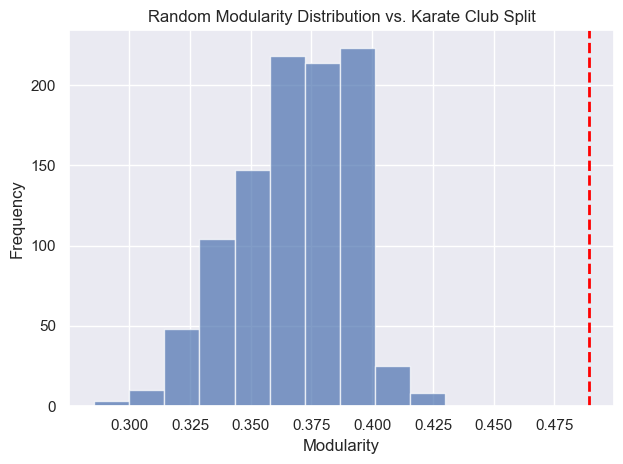

In [31]:
plt.hist(modularity_karate_values, bins=10, alpha=0.7)
plt.axvline(karate_modularity, color='red', linestyle='dashed', linewidth=2)
plt.title("Random Modularity Distribution vs. Karate Club Split")
plt.xlabel("Modularity")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show();

> 8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?


> 9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?


In [ ]:
def louvain_partitions(G):
    partition = community_louvain.best_partition(G)
    groups = defaultdict(set)
    for node, comm in partition.items():
        groups[comm].add(node)
    return list(groups.values())

karate_louvain_partitions = louvain_partitions(G_karate)
karate_louvain_modularity = modularity(G_karate, karate_louvain_partitions)
print(f"The modularity is {karate_louvain_modularity}  with {len(karate_louvain_partitions)}")

The modularity is 0.5498027613412229


> 10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [ ]:
def confusion_matrix(partition1, partition2):
    n_cum1, n_cum2 = len(partition1), len(partition2)
    confusion_matrix = np.zeros((n_cum1, n_cum2))
    for i, comunity1 in enumerate(partition1):
        for j, comunity2 in enumerate(partition2):
            confusion_matrix[i, j] = len(set(comunity1) & set(comunity2))

    return confusion_matrix

karate_confusion_matrix = confusion_matrix(karate_communities, karate_louvain_partitions)

sns.heatmap(karate_confusion_matrix, annot=True,
    yticklabels=[f'Club {i+1}' for i in range(len(karate_communities))],
    xticklabels=[f'Louvain {i+1}' for i in range(len(karate_louvain_partitions))]
)
plt.title('Confusion Matrix: Louvain Communities vs Club Split')
plt.xlabel('Club Split')
plt.ylabel('Louvain Communities')
plt.tight_layout()
plt.show()

## Part 3 - Words that characterize Computational Social Science communities

#### Week 6, Exercise 4

In [ ]:
G_louvain_partitions = louvain_partitions(G)
# G_louvain_modularity = modularity(G, G_louvain_partitions)
# TODO: Store the partitions in a df with author degrees

#### Week 7 (tokenized abstract dataframe)

In [79]:
abstracts_df = pd.read_csv("final_abstracts.csv")
abstracts_df["abstract_inverted_index"] = abstracts_df["abstract_inverted_index"].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else {}
)

In [80]:
def invert_to_text(inverted_index):
    if not inverted_index:
        return ''
    lenght = max(i for p in inverted_index.values() for i in p) + 1
    text = [''] * lenght
    for word, positions in inverted_index.items():
        for i in positions:
            text[i] = word
    return " ".join(text)

# Apply inverted_index function to df
abstracts_df["text"] = abstracts_df["abstract_inverted_index"].apply(invert_to_text)

In [81]:
stemmer = PorterStemmer()
pattern = re.compile(r'https?://\S+|[^a-z\s]')
stop_words = stopwords.words('english')

@lru_cache(maxsize=10000)
def cached_stem(word):
    return stemmer.stem(word)

def tokenize(text, stem=True):
    text = text.lower()
    text = pattern.sub('', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    return [stemmer.stem(t) for t in tokens] if stem else tokens

# TODO - skriv om stemming of tokenize strategi


    Revisit Chapter 3 if you're unfamiliar with tokenization.
    Exclude punctuation, URLs, mathematical symbols, and numbers.
    Convert all text to lowercase.
    Optional: Consider using stemming.


In [82]:
abstracts_df["tokens"] = abstracts_df["text"].apply(tokenize)
tokens = abstracts_df["tokens"].explode()
len(tokens)

In [83]:
len(tokens)

2962444

## Bigrams

These exercises are taken from Week 8
> __Exercise 1: TF-IDF and the Computational Social Science communities.__ The goal for this exercise is to find the words charachterizing each of the communities of Computational Social Scientists.
> What you need for this exercise: 
>    * The assignment of each author to their network community, and the degree of each author (Week 6, Exercise 4). This can be stored in a dataframe or in two dictionaries, as you prefer.  
>    * the tokenized _abstract_ dataframe (Week 7, Exercise 2)
>




> 1. First, check out [the wikipedia page for TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf). Explain in your own words the point of TF-IDF. 
>   * What does TF stand for? 
>   * What does IDF stand for?


TF stands for term frequency, meaning how frequent a term appears in a document. 

IDF stand for inverse document frequency, which is how unique a term is across all documents. As it is inverse the more frequent the lower the score.


> 2. Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 
>   * Consider a community _c_
>   * Find all the abstracts of papers written by a member of community _c_.
>   * Create a long array that stores all the abstract tokens 
>   * Repeat for all the communities. 
> __Note:__ Here, to ensure your code is efficient, you shall exploit ``pandas`` builtin functions, such as [``groupby.apply``](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) or [``explode``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html).



> 3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 
>   * Describe similarities and differences between the communities.
>   * Why aren't the TFs not necessarily a good description of the communities?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?



> 4. We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors). Then for each community: 
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)
>   * Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?



* TF
* IDF

> 2. Now, we want to find out which words are important for each *community*, so we're going to create several ***large documents, one for each community***. Each document includes all the tokens of abstracts written by members of a given community. 
>   * Consider a community _c_
>   * Find all the abstracts of papers written by a member of community _c_.
>   * Create a long array that stores all the abstract tokens 
>   * Repeat for all the communities. 
> __Note:__ Here, to ensure your code is efficient, you shall exploit ``pandas`` builtin functions, such as [``groupby.apply``](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.apply.html) or [``explode``](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html).


> 3. Now, we're ready to calculate the TF for each word. Use the method of your choice to find the top 5 terms within the __top 5 communities__ (by number of authors). 
>   * Describe similarities and differences between the communities.
>   * Why aren't the TFs not necessarily a good description of the communities?
>   * Next, we calculate IDF for every word. 
>   * What base logarithm did you use? Is that important?


> 4. We're ready to calculate TF-IDF. Do that for the __top 9 communities__ (by number of authors). Then for each community: 
>   * List the 10 top TF words 
>   * List the 10 top TF-IDF words
>   * List the top 3 authors (by degree)
>   * Are these 10 words more descriptive of the community? If yes, what is it about IDF that makes the words more informative?


 __Exercise 2: The Wordcloud__. It's time to visualize our results!

> * Install the [`WordCloud`](https://pypi.org/project/wordcloud/) module. 
> * Now, create word-cloud for each community. Feel free to make it as fancy or non-fancy as you like.
> * Make sure that, together with the word cloud, you print the names of the top three authors in each community (see my plot above for inspiration). 
> * Comment on your results. What can you conclude on the different sub-communities in Computational Social Science? 
> * Look up online the top author in each community. In light of your search, do your results make sense?

 

__Exercise 3: Computational Social Science__ 

> * Go back to Week 1, Exercise 1. Revise what you wrote on the topics in Computational Social Science. 
> * In light of your data-driven analysis, has your understanding of the field changed? How? __(max 150 words)__